In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

In [ ]:
url = "/content/01.csv"
data = pd.read_csv(url, delimiter=';')

data.columns = [
    "Timestamp", "CPU cores", "CPU capacity provisioned [MHZ]", "CPU usage [MHZ]",
    "CPU usage [%]", "Memory capacity provisioned [KB]", "Memory usage [KB]",
    "Memory usage [%]", "Disk read throughput [KB/s]", "Disk write throughput [KB/s]",
    "Disk size [GB]", "Network received throughput [KB/s]", "Network transmitted throughput [KB/s]"
]

In [ ]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d.%m.%Y %H:%M:%S')

numeric_columns = data.columns[1:]
for column in numeric_columns:
    data[column] = data[column].astype(str).str.replace(',', '.').astype(float)

data.ffill(inplace=True)
data.bfill(inplace=True)

In [ ]:
features = data.columns.difference(['Timestamp', 'CPU usage [%]'])
target = 'CPU usage [%]'

# Defining sequence length and target shift
sequence_length = 30
target_shift = 60

sequences = []
targets = []
timestamps = []

for i in range(len(data) - sequence_length - target_shift):
    seq = data[features].iloc[i:i+sequence_length].values
    target_value = data[target].iloc[i+target_shift]
    timestamp_value = data['Timestamp'].iloc[i+target_shift]
    sequences.append(seq)
    targets.append(target_value)
    timestamps.append(timestamp_value)

sequences = np.array(sequences)
targets = np.array(targets)

num_samples = min(len(sequences), 7000)
sequences = sequences[:num_samples]
targets = targets[:num_samples]
timestamps = np.array(timestamps)[:num_samples]

scaler = StandardScaler()
sequences = np.reshape(sequences, (sequences.shape[0], -1))
sequences = scaler.fit_transform(sequences)
sequences = np.reshape(sequences, (sequences.shape[0], sequence_length, len(features)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

model = Sequential()

model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.02), activation='swish'),
                        input_shape=(sequence_length, len(features))))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.02), activation='swish')))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.02), activation='swish')))
model.add(Dropout(0.1))

model.add(Dense(1, activation='linear'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - loss: 15217.3496 - mae: 11.7808 - val_loss: 605.2407 - val_mae: 8.4959
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - loss: 972635520.0000 - mae: 1201.2107 - val_loss: 963.2783 - val_mae: 9.7383
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - loss: 9806.3418 - mae: 16.7352 - val_loss: 349.8188 - val_mae: 7.7306
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - loss: 522.0110 - mae: 8.7007 - val_loss: 304.7561 - val_mae: 7.2352
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - loss: 572.9883 - mae: 8.6695 - val_loss: 338.3972 - val_mae: 7.3624
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - loss: 664.2899 - mae: 9.0513 - val_loss: 290.0710 - val_mae: 7.0453
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - loss: 310.0034 - mae: 7.0655 - val_loss: 305.9104 - val_mae: 7.0890
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - loss: 452.0258 - mae: 8.0588 - val_loss: 336.3158 - va

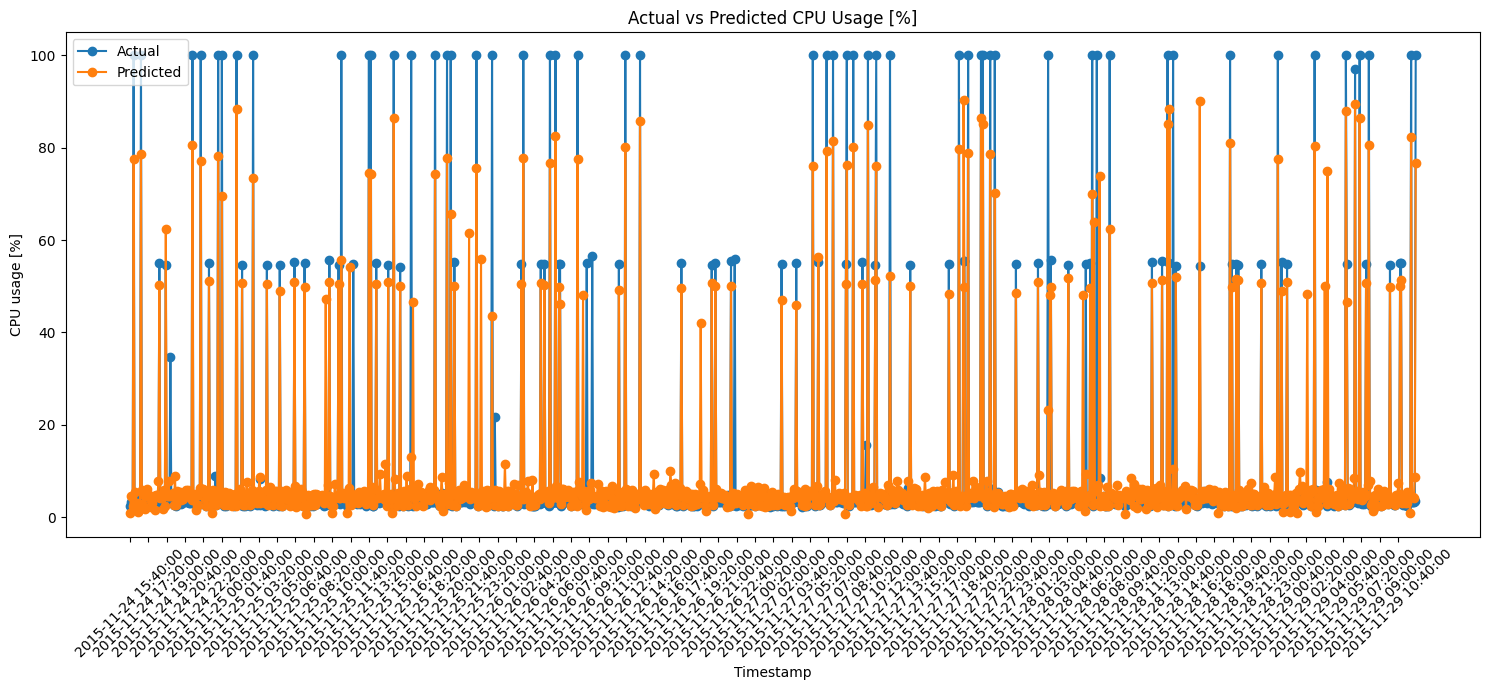

Predictions with time, actual, and predicted CPU usage saved to /content/predictions_validation_cpu_usage.csv


In [ ]:
test_data_indices = np.arange(len(X_test))
timestamps_test = timestamps[-len(X_test):]

predictions_df = pd.DataFrame({
    'Timestamp': timestamps_test,
    'Actual': y_test,
    'Predicted': y_pred.flatten()
})

predictions_df.sort_values(by='Timestamp', inplace=True)
predictions_df['Timestamp'] = pd.to_datetime(predictions_df['Timestamp'])

plt.figure(figsize=(15, 7))
plt.plot(predictions_df['Timestamp'], predictions_df['Actual'], label='Actual', marker='o')
plt.plot(predictions_df['Timestamp'], predictions_df['Predicted'], label='Predicted', marker='o')

plt.xlabel('Timestamp')
plt.ylabel('CPU usage [%]')
plt.title('Actual vs Predicted CPU Usage [%]')
plt.legend()

date_format = DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(predictions_df['Timestamp'][::20], rotation=45)
plt.tight_layout()
plt.show()

# Save the predictions
output_file_predictions = '/content/predictions_validation_cpu_usage.csv'
predictions_df.to_csv(output_file_predictions, index=False)
print(f"Predictions with time, actual, and predicted CPU usage saved to {output_file_predictions}")


https://www.kaggle.com/datasets/kpiyush04/maternaworkloadtraces/data